# Class 4: Machine Learning for Treatment Effects I

- Introduction to Supervised Learning.
- Regression vs Classification.
- Linear models. Logistic Regression.
- Tree-based models.

## Feasible IPW Estimator

Along our derivations and analysis of treatment effect estimators using the propensity score $e(X_i)$, we were assuming that the scores were known. In reality however, we won't have access to the true propensity scores. This means that we will have to construct them somehow using the data we have. Using estimated propensity scores $\hat{e}(X_i)$ in IPW leads to the **"feasible" IPW estimator** $\hat{\tau}_{IPW}$ (as opposed to the "oracle" IPW, when we use the true propensities $\hat{\tau}_{IPW^*}$).

It can be shown that, if $\hat{e}(X_i)$ is a consistent estimator of $e(X_i)$, $\hat{\tau}_{IPW}$ will be consistent for $\tau$ as:

$$|\hat{\tau}_{IPW} - \hat{\tau}_{IPW^*}| \overset{p}{\to} 0$$

Therefore, our task is to come up with a consistent set of propensity scores. And here is where Machine Learning excels. 

## Supervised Learning

The language line is blurry, but it is said that we face a **prediction** problem when we try to obtain individual values for a random variable from the available data, as opposed to an **estimation** problem when we try to obtain an estimate of a parameter also from the available data. We estimate treatment effects or variances; we predict propensity scores or outcomes.   

In Machine Learning we deal mostly with prediction problems, where we have a set of inputs or features $X_i$ that we use to guess an output, target or label $Y_i$. Problems like these fall into the category of **Supervised Learning**.

Conceptually, a supervised learning problem is easy to define. We want to predict the value of some target $Y_i$ which is related to our features $X_i$ via some function $f$. We can write this relationship as:

$$Y_i = f(X_i) + \varepsilon_i$$

In other words, we want to come up with an $\hat{f}$ that best approximates $f$.

$Y_i$ can theoretically be anything, like a scalar, a vector, a matrix. It can also be a class among a set of possible classes, or a sequence of elements, for example a sequence of tokens representing our own language 😉.

The last component that defines a supervised learning problem is the **loss function**. A loss function $L(Y, f(X))$ is a function that penalizes the prediction error which we want to minimize.

The choice of the loss function will determine the shape of $\hat{f}$. For example, when $Y_i$ is a scalar, the most common choice of loss is the **mean squared error (MSE)**:

$$MSE = \mathbb{E}[(Y_i - f(X_i))^2]$$

Note that we can condition on $X_i$ to get:

$$MSE = \mathbb{E}\left[\mathbb{E}[(Y_i - f(x))^2]|X=x\right]$$

And we minimize choosing $f$ to obtain:

$$f(x) = \mathbb{E}[Y_i|X_i=x]$$

Which means that the conditional expectation of $Y_i$ given $X_i = x$ gives us the best prediction of $Y_i$, where best is measured by our MSE loss. If, for example, we chose to use the mean absolute error (MAE) as loss function instead, we would see that the $f$ that minimizes MAE is the conditional median.


## Regression vs Classification

Informally, there are two main categories of supervised learning problems depending on what is our target $Y_i$. If $Y_i$ is numeric (for example, a scalar or a vector), we say we are dealing with a **regression** problem. For example, if we are trying to predict household income, cholesterol levels, or the estimated time of a delivery. If $Y_i$ is a class from a well defined set of classes, we say we have a **classification** problem. For example, when we try to determine whether a customer is fraudulent or not, or when we are trying to classify an image as a dog, cat, or bird.

Each type of problem has its own characteristics, but in some cases the line between a regression and a classification problem is algorithmically (but not conceptually) blurry. For example, sometimes we might use a loss function intended for a classification problem to solve a regression problem, or viceversa. In fact, propensity score prediction is one of these blurry cases. We will see why in a moment.

## Linear Models

Let's dive into our main objective: propensity score prediction. We want to predict the propensity scores $e(X_i)$ using $X_i$. We know that $e(X_i) = \mathbb{P}[W_i = 1 |X_i=x] = \mathbb{E}[W_i|X_i=x]$. At first glance, this looks like a simple regression problem where $W_i$ is the target, so why don't we try to solve it by minimizing MSE? We know that we minimize MSE if we set $f$ to the conditional expectation $\mathbb{E}[W_i|X_i=x]$. So we now need to model this conditional expectation function of $x$. Let's start with arguably the simplest specification we can use: a linear model.

$$f(x) = x\beta$$

Let's simulate our observational DGP and see how the linear model does at predicting the propensity score.

\begin{align*}
i &= 1,\ldots, n\\
X_{ij} &\overset{iid}{\sim} \mathcal{U}(-1, 1), \; j \in \{1,2,3\}\\
e(X_i) &= 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}\\
W_i &\sim Ber(e(X_i))\\
Y_i &= \text{exp}(X_{1i} + X_{2i}) + \text{max}\{0,X_{3i}\} W_i  
\end{align*}

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

# Disable scientific notation in notebook output
pd.options.display.float_format = "{:.6f}".format
np.set_printoptions(suppress=True)

In [2]:
n = 100_000  # sample size

np.random.seed(42)

# X_ij ~ U(-1, 1) iid for j in {1, 2, 3}
X = np.random.uniform(-1, 1, size=(n, 3))

# e(X_i) = 0.1 + 0.85 * sqrt(max{0, 1 + X_2i + X_3i} / 3)
e_X = 0.1 + 0.85 * np.sqrt(np.maximum(0, 1 + X[:, 1] + X[:, 2]) / 3)

# W_i ~ Ber(e(X_i))
W = np.random.binomial(1, e_X, size=n)

# Y_i = exp(X_1i + X_2i) + max{0, X_3i} * W_i
Y = np.exp(X[:, 0] + X[:, 1]) + np.maximum(0, X[:, 2]) * W

df = pd.DataFrame({
    "Y": Y,
    "W": W,
    "X1": X[:, 0],
    "X2": X[:, 1],
    "X3": X[:, 2],
    "prop": e_X
})

In [3]:
df.head()

,Y,W,X1,X2,X3,prop
0,2.380504,1,-0.250920,0.901429,0.463988,0.854766
1,0.612231,0,0.197317,-0.687963,-0.688011,0.100000
2,1.061665,1,-0.883833,0.732352,0.202230,0.782577
3,1.521005,1,0.416145,-0.958831,0.939820,0.586060
4,1.093697,0,0.664885,-0.575322,-0.636350,0.100000


In [4]:
df.describe()

,Y,W,X1,X2,X3,prop
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.563379,0.542160,0.001677,0.000271,0.000937,0.544769
std,1.230819,0.498222,0.576880,0.577664,0.577146,0.230795
min,0.136148,0.000000,-0.999989,-0.999977,-0.999995,0.100000
25%,0.682901,0.000000,-0.496322,-0.501154,-0.501503,0.415292
50%,1.215131,1.000000,0.002561,0.002313,0.002099,0.590926
75%,2.044180,1.000000,0.500849,0.499861,0.499962,0.718551
max,7.905609,1.000000,0.999984,0.999966,0.999979,0.948683


In [5]:
linear_model = LinearRegression().fit(df[["X1", "X2", "X3"]], df["W"])

In [6]:
df['prop_pred_linear'] = linear_model.predict(df[["X1", "X2", "X3"]])

In [7]:
df['prop_pred_linear'].describe()

count   100000.000000
mean         0.542160
std          0.226358
min         -0.007569
25%          0.379271
50%          0.542205
75%          0.704745
max          1.092843
Name: prop_pred_linear, dtype: float64

In [8]:
def plot_propensity_densities(df, true_prop='prop', pred_prop='prop', ax=None):
    """Plot density of true vs predicted propensity scores."""
    if ax is None:
        fig, ax = plt.subplots()
    true_prop = df[true_prop]
    pred_prop = df[pred_prop]
    x = np.linspace(-0.1, 1.1, 200)
    ax.plot(x, gaussian_kde(true_prop)(x), label="True", color="C0")
    ax.plot(x, gaussian_kde(pred_prop)(x), label="Predicted", color="C1")
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("Density")
    ax.legend()
    return ax

<Axes: xlabel='Propensity score', ylabel='Density'>

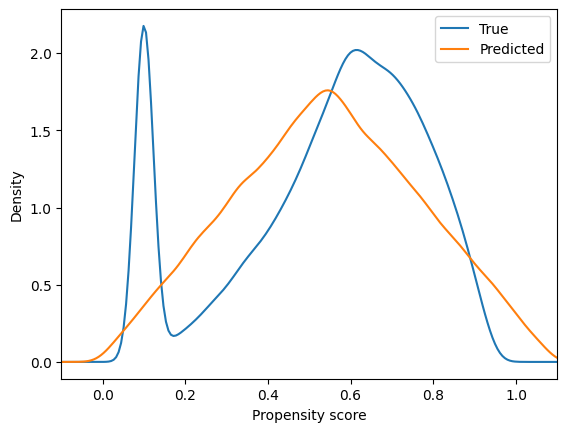

In [9]:
plot_propensity_densities(df,'prop','prop_pred_linear')

Something seems off. We are trying to predict a probability, but we are getting values beyond $0$ and $1$, which we know can't be possible. We could always clip the predictions to fall into this range but we want to avoid that kind of discretionary decisions. Let's try that approach to at least compute feasible IPW.

In [10]:
df['prop_pred_linear_clipped'] = np.clip(df['prop_pred_linear'], 0.01, 0.99)
df['prop_pred_linear_clipped'].describe()

count   100000.000000
mean         0.541500
std          0.224941
min          0.010000
25%          0.379271
50%          0.542205
75%          0.704745
max          0.990000
Name: prop_pred_linear_clipped, dtype: float64

In [11]:
def ipw_ate(df, propensity_col, y_col="Y", w_col="W"):
    """
    Estimate the average treatment effect (ATE) using inverse probability weighting.

    τ̂_IPW = (1/n) Σ [ W_i * Y_i / e(X_i) - (1 - W_i) * Y_i / (1 - e(X_i)) ]

    Standard error is computed from the sample variance of the IPW score (influence) terms.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with outcome, treatment, and propensity score.
    propensity_col : str
        Name of the column containing the propensity score e(X) = P(W=1|X).
    y_col : str, default "Y"
        Name of the outcome column.
    w_col : str, default "W"
        Name of the treatment indicator column (0/1).

    Returns
    -------
    tuple of (float, float)
        (tau_hat, standard_error).

    Raises
    ------
    ValueError
        If any propensity score is not in (0, 1) (overlap does not hold).
    """
    e = df[propensity_col].values
    if np.any(e <= 0) or np.any(e >= 1):
        raise ValueError(
            "Overlap does not hold: all propensity scores must be strictly in (0, 1). "
            "Found values outside this range."
        )
    y = df[y_col].values
    w = df[w_col].values
    n = len(df)
    # IPW score: ψ_i = W_i*Y_i/e_i - (1-W_i)*Y_i/(1-e_i)
    scores = (w * y / e) - ((1 - w) * y / (1 - e))
    tau_hat = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(n)
    return float(tau_hat), float(se)

In [12]:
ipw_ate(df,propensity_col='prop')

(0.24309745978275038, 0.014498603659518557)

In [13]:
ipw_ate(df,propensity_col='prop_pred_linear_clipped')

(-0.3422027049098221, 0.04685139218460708)

This is a well-known limitation of linear models when used to predict probabilities: there is nothing in the specification of the linear model that prevents predictions from falling outside the $[0,1]$ range.

## Logistic Regression

When thinking about the propensity score prediction problem, there is some classification flavor to it: There is a variable $W_i$ that indicates unit $i$ belongs to one of two classes, treatment or control. We are not really interested in predicting which class each units belongs to (treatment status is actually observable), but perhaps we can borrow some of the methods used to handle classification problems.

Logistic regression starts from assuming that the log-odds of the target variable are a linear function of the features.

$$\text{log}\left(\frac{\mathbb{P}[W_i = 1 |X_i=x]}{\mathbb{P}[W_i = 0 |X_i=x]}\right) = x\beta$$

 Incorporating the fact that the probabilities must sum to $1$, the model becomes completely specified and it is straight-forward to see that:

\begin{align*}
\mathbb{P}[W_i = 1 |X_i=x] &= \frac{\text{exp}(x\beta)}{1+\text{exp}(x\beta)}\\
\mathbb{P}[W_i = 0 |X_i=x] &= \frac{1}{1+\text{exp}(x\beta)}\\
\end{align*}

Note that we arbitrarily chose $W_i = 0$ to be the "base class", and the log-odds will be defined with respect to this class, but results are actually invariant to which class we choose as "base".

How do we fit this model? Because we have the specification for each of the probabilities of this discrete group of classes, we have a completely specified multinomial distribution. Thus, it is very reasonable that we attempt a maximum likelihood approach. The likelihood function for this problem is (we still assume $iid$ observations):

\begin{align*}
\mathcal{L}(\beta) &\propto \prod_i \prod_k \mathbb{P}[W_i = k |X_i=x_i]^{\mathcal{I}\{W_i = k\}}\\
\end{align*}

with $k \in \{0,1\}$ for all $i$. We can take logs and obtain a simpler log-likelihood function by operating algebraically and using our model specification:

\begin{align*}
\mathcal{l}(\beta) &= \sum_i \sum_k \text{log}\left(\mathbb{P}[W_i = k |X_i=x_i]^{\mathcal{I}\{W_i = k\}}\right)\\
\mathcal{l}(\beta) &= \sum_i \sum_k \left\{ {\mathcal{I}\{W_i = k\}}\text{log}\left(\mathbb{P}[W_i = k |X_i=x_i]\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i\text{ log}\left(\mathbb{P}[W_i = 1 |X_i=x_i]\right) + (1-W_i)\text{ log}\left(\mathbb{P}[W_i = 0 |X_i=x_i]\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i\text{ log}\left(\frac{\text{exp}(x_i\beta)}{1+\text{exp}(x_i\beta)}\right) + (1-W_i)\text{ log}\left(\frac{1}{1+\text{exp}(x_i\beta)}\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i x_i\beta - \text{log}\left(1+ \text{exp}(x_i\beta)\right)\right\}\\
\end{align*}

One can then take derivatives to obtain the set score equations and solve the system using some numerical method, as its solution does not typically have a closed form.

Let's fit a Logistic model and observe what predictions look like.

In [14]:
logit_model = LogisticRegression().fit(df[["X1", "X2", "X3"]], df["W"])

In [15]:
df['prop_pred_logistic'] = logit_model.predict_proba(df[["X1", "X2", "X3"]])[:,1]

In [16]:
df['prop_pred_logistic'].describe()

count   100000.000000
mean         0.542115
std          0.227585
min          0.077329
25%          0.357954
50%          0.553335
75%          0.733126
max          0.948437
Name: prop_pred_logistic, dtype: float64

In [17]:
ipw_ate(df,propensity_col = 'prop_pred_logistic')

(0.17040032781248018, 0.016007053072702435)

<Axes: xlabel='Propensity score', ylabel='Density'>

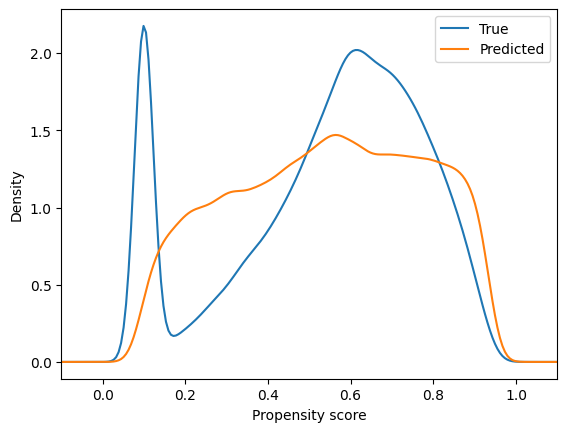

In [18]:
plot_propensity_densities(df,'prop','prop_pred_logistic')

Looks better but it is still very far off. How about the stratified estimator?

In [19]:
def stratified_ate(
    df,
    propensity_col,
    strata_bounds,
    y_col="Y",
    w_col="W",
):
    """
    Estimate the ATE using the propensity-score stratified estimator.

    Units are binned by propensity score using strata_bounds; within each stratum
    the conditional ATE is estimated by difference-in-means, then aggregated
    with weights n_x / n.

    τ̂_STRAT = Σ_x (n_x / n) * τ̂(x),   τ̂(x) = E[Y|W=1,X∈stratum x] - E[Y|W=0,X∈stratum x]

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with outcome, treatment, and propensity score.
    propensity_col : str
        Name of the column containing the propensity score e(X) = P(W=1|X).
    strata_bounds : int or array-like
        If int: number of strata; bounds are np.linspace(0, 1, strata_bounds + 1).
        If array-like: 1d array of bin edges (length = number of strata + 1).
    y_col : str, default "Y"
        Name of the outcome column.
    w_col : str, default "W"
        Name of the treatment indicator column (0/1).

    Returns
    -------
    float
        Stratified estimate of the ATE.
    """
    e = df[propensity_col].values
    y = df[y_col].values
    w = df[w_col].values
    n = len(df)

    if np.isscalar(strata_bounds) and isinstance(strata_bounds, (int, np.integer)):
        bounds = np.linspace(0.0, 1.0, int(strata_bounds) + 1)
    else:
        bounds = np.asarray(strata_bounds, dtype=float)
    if bounds.ndim != 1 or len(bounds) < 2:
        raise ValueError("strata_bounds must be an int or a 1d array of at least 2 edges.")

    # Assign stratum: (bounds[0], bounds[1]], (bounds[1], bounds[2]], ..., (bounds[-2], bounds[-1]]
    stratum = np.digitize(e, bounds, right=False) - 1
    # clip so e exactly equal to bounds[-1] stays in last stratum
    stratum = np.clip(stratum, 0, len(bounds) - 2)

    tau_hat = 0.0
    for s in range(len(bounds) - 1):
        mask = stratum == s
        n_x = np.sum(mask)
        if n_x == 0:
            continue
        w1 = mask & (w == 1)
        w0 = mask & (w == 0)
        n_x1 = np.sum(w1)
        n_x0 = np.sum(w0)
        if n_x1 == 0 or n_x0 == 0:
            raise ValueError(
                f"Overlap does not hold in stratum {s} (e in ({bounds[s]:.4f}, {bounds[s+1]:.4f}]): "
                "need both treated and control units."
            )
        mean1 = np.sum(np.where(w1, y, 0.0)) / n_x1
        mean0 = np.sum(np.where(w0, y, 0.0)) / n_x0
        tau_x = mean1 - mean0
        tau_hat += (n_x / n) * tau_x

    return float(tau_hat)

In [20]:
stratified_ate(df,propensity_col='prop_pred_logistic',strata_bounds=20)

0.2540299088742501

Much closer. It seems that the stratified estimator gets around the gap between the predicted and real propensities better. Will this work with the linear propensity model as well?

In [21]:
stratified_ate(df,propensity_col='prop_pred_linear',strata_bounds=20)

0.2534077297136591

Why is the case that the stratified estimator works better? Let's look at how we are creating the propensity score as a function of $X_i$:

$$e(X_i) = 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}$$

It is clear that the propensity score is not well specified neither with the linear nor logistic models. However, despite being non-linear, the relationship between the propensities and the covariates is simple enough that the two models have a very good chance of approximating it, at least directionally. Let's visualize that:      

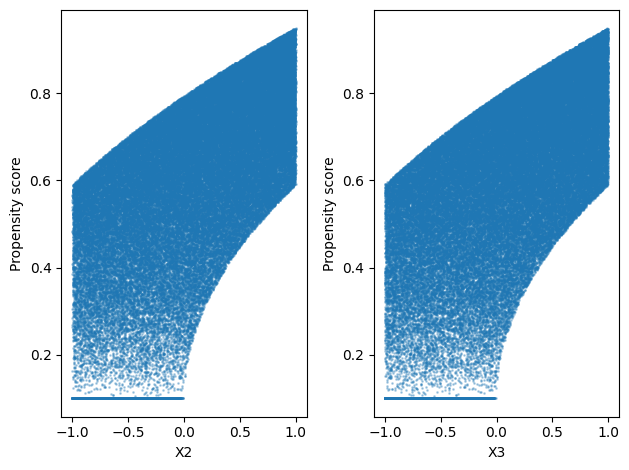

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df["X2"], df["prop"], s=1, alpha=0.3)
ax1.set_xlabel("X2")
ax1.set_ylabel("Propensity score")
ax2.scatter(df["X3"], df["prop"], s=1, alpha=0.3)
ax2.set_xlabel("X3")
ax2.set_ylabel("Propensity score")
plt.tight_layout()

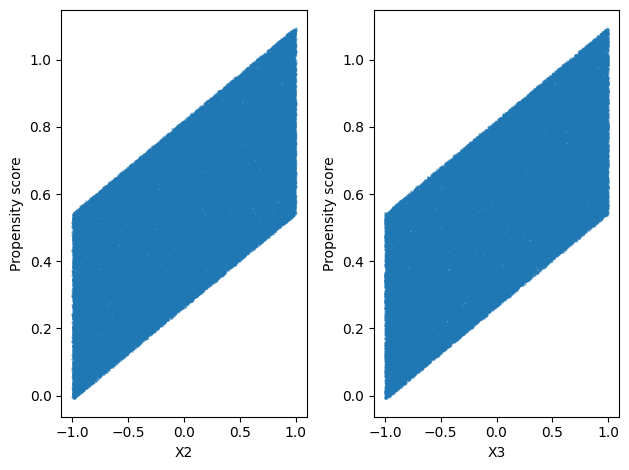

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df["X2"], df["prop_pred_linear"], s=1, alpha=0.3)
ax1.set_xlabel("X2")
ax1.set_ylabel("Propensity score")
ax2.scatter(df["X3"], df["prop_pred_linear"], s=1, alpha=0.3)
ax2.set_xlabel("X3")
ax2.set_ylabel("Propensity score")
plt.tight_layout()

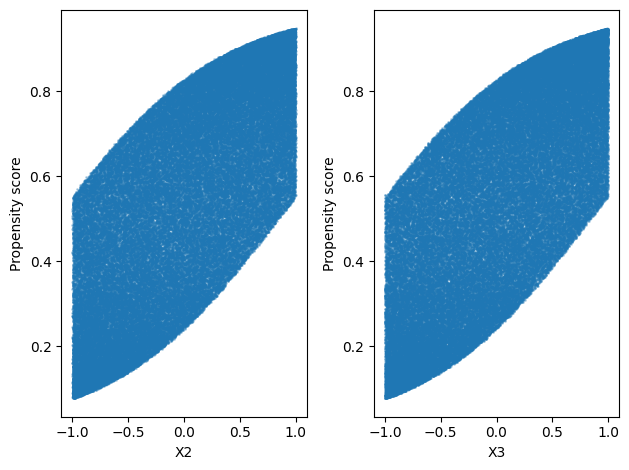

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df["X2"], df["prop_pred_logistic"], s=1, alpha=0.3)
ax1.set_xlabel("X2")
ax1.set_ylabel("Propensity score")
ax2.scatter(df["X3"], df["prop_pred_logistic"], s=1, alpha=0.3)
ax2.set_xlabel("X3")
ax2.set_ylabel("Propensity score")
plt.tight_layout()

The stratified estimator is more robust to discrepancies between the predicted and actual propensity score and much more robust to extreme values of the propensity score. Hence, with a model that works at least directionally, it makes sense that it estimates the treatment effect reasonably well. Because our predicted propensity scores are not consistent, feasible IPW will drastically fail.

## Tree-based Models

Linearity limitations can be sorted through a number of approaches. For example, we could add interaction terms to our linear specification, but the model can become saturated pretty quickly. An alternative algorithm that helps overcoming this limitation is the **decision tree**. Decision trees are conceptually very simple, but they are also really powerful as they can fit non-linear relationships extremely well. Therefore, tree-based models became extremely prominent in Machine Learning applications.

A decision tree is constructed by partitioning the feature space $\mathcal{X}$ into regions $R_1, \ldots, R_M$. We will assign a predicted value to the units belonging to that region through a region-specific function $f_m(X_i)$. As always, we want to minimize the predicted error, so we want that predicted value to be as accurate as possible. There are two components of the algorithm that we need to specify. First, how we define the regions. Second, our choice of $f_m(X_i)$ for each of the $M$ regions.

Let's start with the latter, as it is a special case of the type of problems that we faced before. Our choice of $f_m(X_i)$ will depend on the loss function we want to minimize. For example, if we want to use MSE as our loss function, $f_m(X_i)$ should be the conditional expectation. This is usually the case for regression trees, and we typically set $\hat{f}_m(X_i)$ to a constant (the constant that minimizes MSE in this case is the sample mean from the observations belonging to that region).

Now, how do we define the regions? For continuous, high-dimensional $\mathcal{X}$, it is obviously infeasible to compute all the possible partitions, compute the MSE (or whatever loss we want to use), and choose the partition that minimizes the global MSE. The standard approach is to do it sequentially, using a "greedy" algorithm. We start at the "root" of the tree, and "evaluate" all possible binary splits across our covariates and their values. "Evaluate" here means estimating the total MSE (adding it up region by region) and choosing the split that minimizes it. After we find the split, we assign units to each of the regions depending on whether they fall to one side of the split or the other. For example, if the split is set at $X_{1i} \geq 0$, all units with $x_i \geq 0$ will belong to one region, and all units with $x_i < 0$ will belong to the other region. Then, we repeat the process sequentially treating as root each of the regions. We continue doing this until the next split of the feature space does not reduce the total MSE.  

Note the "greedy" fashion of the algorithm: when defining a split we only care about how the MSE changes on that step, without looking ahead on how the split conditions potential subsequent splits.

Classification trees work similarly, and we have a number of options for loss functions that are common. Within each region, we choose among the two classes, $0$ or $1$ that minimizes the loss of our choice. Letting $\hat{p} = \frac{1}{n_m}\sum_{x_i \in R_m} \mathcal{I}\{y_i = 1\}$ be the proportion of observations belonging to class $1$, a common choice for loss function is naturally the (negative) log-likelihood we derived above:

$$L(y_i,f_m(X_i)) = -\left[p\text{ log}(p)+(1-p)\text{ log}(1-p)\right]$$

But there are others that penalize the "impurity" of the regions more harshly, for example the misclassification error:

$$L(y_i,f_m(X_i)) = 1-\text{max}\{p, 1-p\}$$

or Gini index:

$$L(y_i,f_m(X_i)) = p(1-p)$$

Because our propensity scores problem is a bit of a hybrid case, let's try both a regression and classification tree and study the differences.

In [ ]:
tree_model = DecisionTreeRegressor().fit(df[["X1", "X2", "X3"]], df["W"])

In [28]:
df['prop_pred_reg_tree'] = tree_model.predict(df[["X1", "X2", "X3"]])

In [29]:
df['prop_pred_reg_tree'].describe()

count   100000.000000
mean         0.542160
std          0.498222
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: prop_pred_reg_tree, dtype: float64

In [32]:
tree_model_2 = DecisionTreeClassifier().fit(df[["X1", "X2", "X3"]], df["W"])

In [33]:
df['prop_pred_class_tree'] = tree_model_2.predict_proba(df[["X1", "X2", "X3"]])[:,1]
df['prop_pred_class_tree'].describe()

count   100000.000000
mean         0.542160
std          0.498222
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: prop_pred_class_tree, dtype: float64

Interesting! The tree is predicting only two values for the propensities: 0 and 1. Why could this be happening?

Let's try fitting a tree limiting its depth.

In [37]:
tree_model_md3 = DecisionTreeRegressor(max_depth = 3).fit(df[["X1", "X2", "X3"]], df["W"])
df['prop_pred_tree_md3'] = tree_model_md3.predict(df[["X1", "X2", "X3"]])
df['prop_pred_tree_md3'].describe()

count   100000.000000
mean         0.542160
std          0.217421
min          0.118368
25%          0.438088
50%          0.616442
75%          0.717935
max          0.827560
Name: prop_pred_tree_md3, dtype: float64

In [40]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_tree(tree_model_md3, feature_names=["X1", "X2", "X3"], ax=ax)
# plt.tight_layout()

<Axes: xlabel='Propensity score', ylabel='Density'>

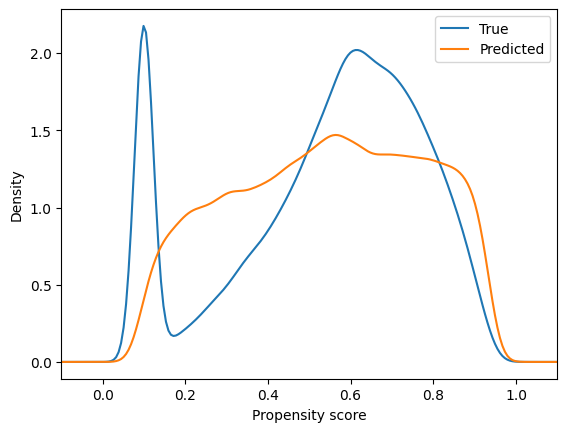

In [42]:
plot_propensity_densities(df,'prop','prop_pred_logistic')

<Axes: xlabel='Propensity score', ylabel='Density'>

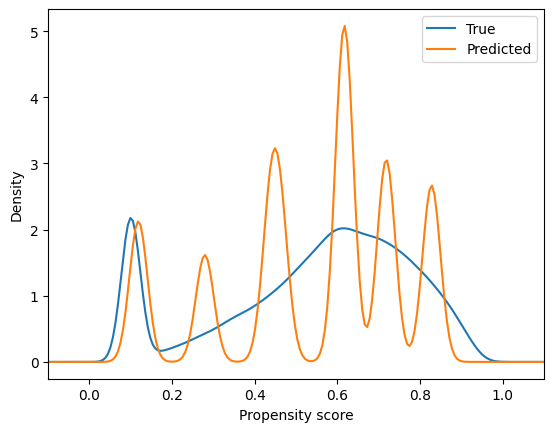

In [41]:
plot_propensity_densities(df,'prop','prop_pred_tree_md3')

In [43]:
ipw_ate(df,propensity_col = 'prop_pred_tree_md3')

(0.36547447770279096, 0.013057590479538103)

Let's try increasing the max depth.

In [45]:
tree_model_md6 = DecisionTreeRegressor(max_depth = 6).fit(df[["X1", "X2", "X3"]], df["W"])
df['prop_pred_tree_md6'] = tree_model_md6.predict(df[["X1", "X2", "X3"]])
df['prop_pred_tree_md6'].describe()

count   100000.000000
mean         0.542160
std          0.233394
min          0.088692
25%          0.415744
50%          0.593750
75%          0.714870
max          1.000000
Name: prop_pred_tree_md6, dtype: float64

In [47]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_tree(tree_model_md6, feature_names=["X1", "X2", "X3"], ax=ax)
# plt.tight_layout()

<Axes: xlabel='Propensity score', ylabel='Density'>

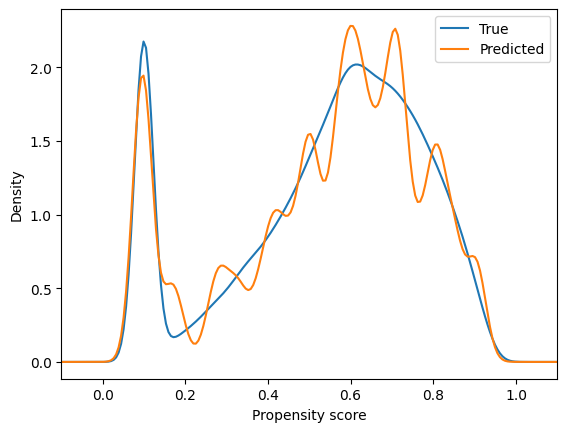

In [48]:
plot_propensity_densities(df,'prop','prop_pred_tree_md6')

In [49]:
tree_model_md15 = DecisionTreeRegressor(max_depth = 15).fit(df[["X1", "X2", "X3"]], df["W"])
df['prop_pred_tree_md15'] = tree_model_md15.predict(df[["X1", "X2", "X3"]])
df['prop_pred_tree_md15'].describe()

count   100000.000000
mean         0.542160
std          0.307784
min          0.000000
25%          0.303571
50%          0.599824
75%          0.771429
max          1.000000
Name: prop_pred_tree_md15, dtype: float64

<Axes: xlabel='Propensity score', ylabel='Density'>

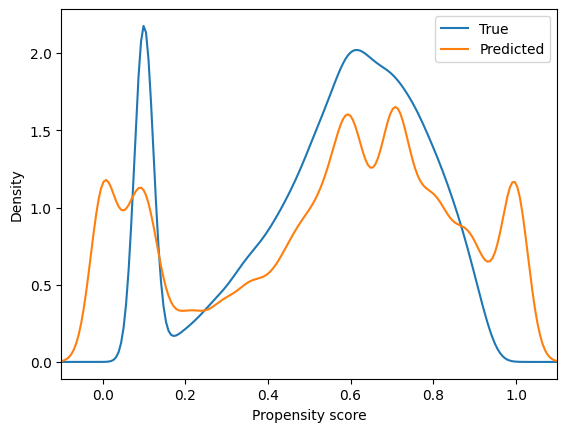

In [50]:
plot_propensity_densities(df,'prop','prop_pred_tree_md15')